In [1]:
import sys, os
sys.path.insert(1, os.path.join(os.getcwd(), "src"))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from my_library import read_log
from pprint import pprint

%matplotlib inline

In [34]:
TEST_RESULTS_DIR = "log_files"

results_dir = os.path.join(os.getcwd(), TEST_RESULTS_DIR)
files = os.listdir(results_dir)
files = [f for f in files if "_avg" in f] # average files only
files.sort()


# !ls -1 {results_dir}
# print()
# pprint(files)

In [35]:
# FILTER RESULT FILES

# ALL
selected_files = files
# FIILTER IF CONTAINS STRINGS
select_str = ["mnist", "localiter_1", "rate_7"]
# select_str = ["test", "C"]
for s in select_str:
    selected_files = [f for f in selected_files if s in f]

# LOAD RESULTS FROM SELECTED FILES
selected_files = [os.path.join(results_dir,f) for f in selected_files]
data = []
for f in selected_files:
    data.append(read_log(f))
pprint(selected_files)
print()
print(f"Loaded {len(data)} result files.")


['/home/as6316/wireless-HFL/log_files/mnist-rate_7-mobility_0_10-localiter_1_avg.json',
 '/home/as6316/wireless-HFL/log_files/mnist-rate_7-mobility_0_20-localiter_1_avg.json',
 '/home/as6316/wireless-HFL/log_files/mnist-rate_7-mobility_0_30-localiter_1_avg.json',
 '/home/as6316/wireless-HFL/log_files/mnist-rate_7-static-localiter_1_avg.json']

Loaded 4 result files.


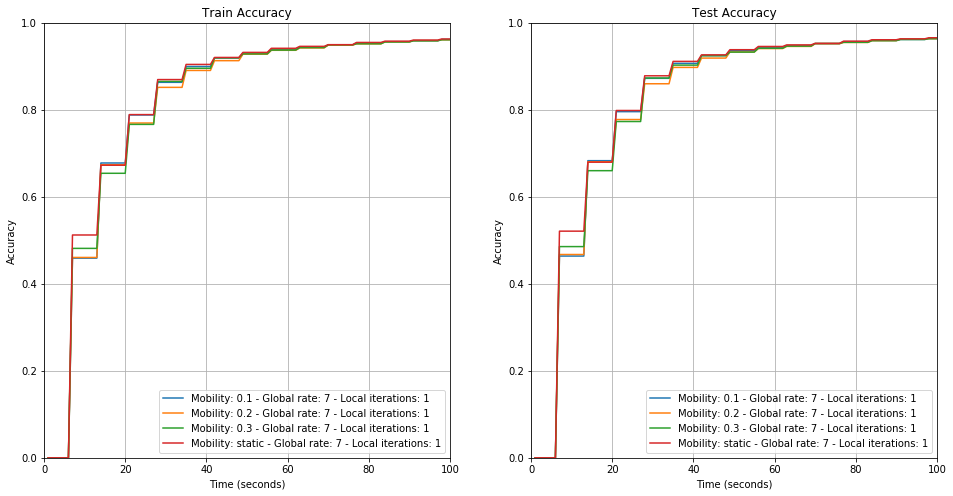

In [31]:
def make_label(config, rule):
    label = ""
    for r in rule: 
        if r == "server_global_rate":
            label += f"Global rate: {config[r]} - "
        elif r == "mobility_rate":
            label += f"Mobility: {config[r] if config['clients_mobility'] else 'static'} - "
        elif r == "client_n_epochs":
            label += f"Local iterations: {config[r]} - "
    # print(label)
    return label[:-3]

# PLOT RESULTS
plt.figure(figsize=(16,8))
for acc_id, acc_name in enumerate(["train_accuracy", "test_accuracy"]):
    plt.subplot(1,2,acc_id+1)
    plt.title("Train Accuracy" if acc_name=="train_accuracy" else "Test Accuracy")
    max_x = 0
    for r_idx,r in enumerate(data):
        rounds = r["results"]["rounds"]
        avg_latency = np.mean(r["results"]["latency"])
        X = [round_*avg_latency for round_ in rounds]
        X =rounds
        # X = np.cumsum(r["results"]["latency"])
        acc = r["results"][acc_name]
        label = make_label(r["config"],
                           rule=["mobility_rate", "server_global_rate", "client_n_epochs"])

        plt.plot(X, acc, label=label)
        max_x = max(max_x, max(X))
    plt.ylim(0,1)
    plt.xlim(0,max_x)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
plt.show()